Enter area width (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 4):  5
Enter minimum radius (e.g. 5):  10
Enter maximum radius (e.g. 20):  20
Enter fixed part cost per sensor (e.g. 10):  100



⚙️ Start Optimization...
No constraints given.
Best after iteration 1: [49.66963177 63.90531787 19.83731872 30.94064543 38.0935375  13.85235287
 84.01847365 97.90704524 19.7736775  39.19096459 94.77020974 17.95127236
 18.53912821 21.35120042 18.97481281] -3703.844226290447
Best after iteration 2: [49.66963177 63.90531787 19.83731872 30.94064543 38.0935375  13.85235287
 84.01847365 97.90704524 19.7736775  39.19096459 94.77020974 17.95127236
 18.53912821 21.35120042 18.97481281] -3703.844226290447
Best after iteration 3: [49.66963177 63.90531787 19.83731872 30.94064543 38.0935375  13.85235287
 84.01847365 97.90704524 19.7736775  39.19096459 94.77020974 17.95127236
 18.53912821 21.35120042 18.97481281] -3703.844226290447
New best for swarm at iteration 4: [ 8.0501052  75.71420667 20.         49.67545254 87.86486811 14.86147446
 86.80488023 87.82128128 20.         61.30331629 57.91403381 19.18879189
  8.25689971 20.48590322 18.05446096] -4211.158109073422
Best after iteration 4: [ 8.05010

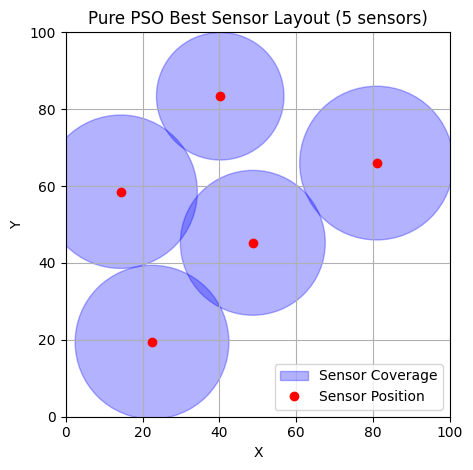

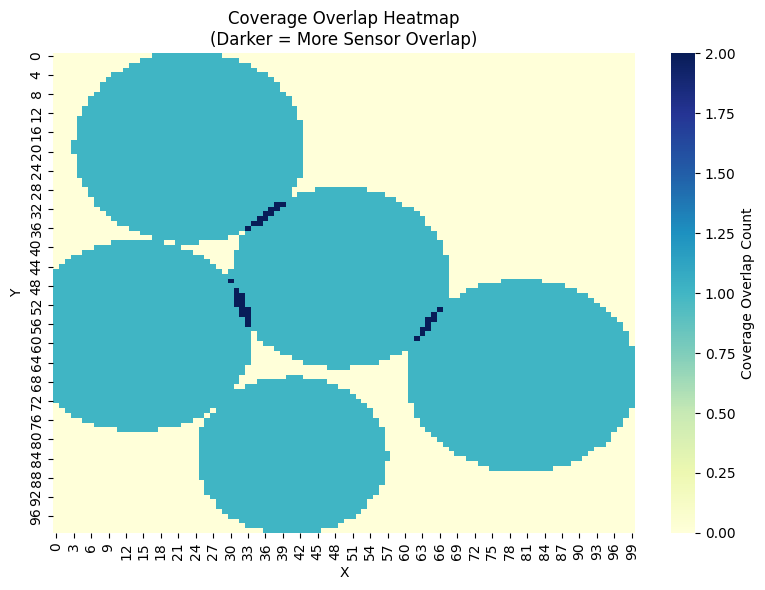

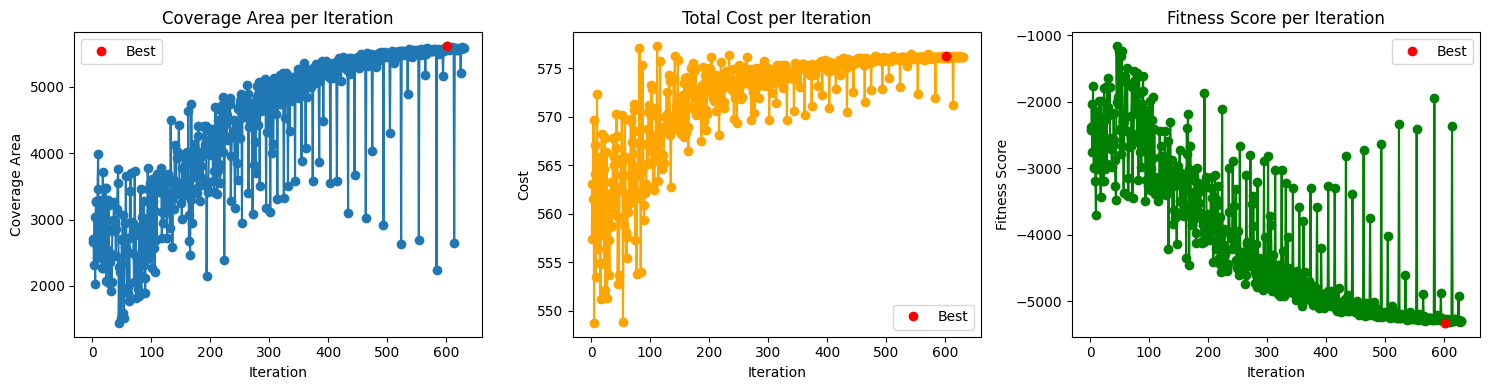

In [4]:
#纯pso 作为对比方案
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso
import time


t0 = time.perf_counter()

# ---------------- 1. user input ----------------
area_width   = int(input("Enter area width (e.g. 100): "))
area_height  = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min        = float(input("Enter minimum radius (e.g. 5): "))
r_max        = float(input("Enter maximum radius (e.g. 20): "))

# >>> cost parameters (match Hybrid version) <<<
fixed_cost        = float(input("Enter fixed part cost per sensor (e.g. 10): "))
COST_PER_RADIUS   = 0.8          # extra cost per unit radius  #### <<< changed >>> 

radius_bounds = (r_min, r_max)
grid_resolution = 1

x_coords = np.arange(0, area_width , grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy   = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

fitness_history = []
coverage_history = []
cost_history     = []
position_history = []

# ---------------- 2. fitness function ----------------
def fitness_function(particle):
    global last_heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat          = np.zeros(len(grid_points), dtype=int)
    total_cost    = 0.0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]

        dist = np.sqrt((grid_points[:, 0] - x) ** 2 +
                       (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat         += covered.astype(int)

        # ------ cost model aligned with Hybrid code ------
        total_cost += fixed_cost + COST_PER_RADIUS * r      #### <<< changed >>>

    coverage_score = np.sum(total_covered)
    fitness = -coverage_score + 0.5 * total_cost            #### <<< changed >>>

    # history
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)
    position_history.append(particle.copy())
    last_heatmap = heat
    return fitness

# ---------------- 3. PSO bounds ----------------
lb, ub = [], []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# ---------------- 4. run PSO ----------------
print("\n⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# ---------------- 5. trace best history ----------------
for i in range(len(fitness_history)):
    if i == 0 or fitness_history[i] < min(fitness_history[:i]):
        print(f"New best for swarm at iteration {i+1}: {position_history[i]} {fitness_history[i]}")
    if i == len(fitness_history) - 1:
        print(f"Best after iteration {i+1}: {position_history[i]} {fitness_history[i]}")
print("Stopping search: maximum iterations reached --> 20")

# ---------------- 6. summary ----------------
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0.0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    total_covered |= dist <= r
    total_cost += fixed_cost + COST_PER_RADIUS * r          #### <<< changed >>>

print(f"\n📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")
pure_elapsed = time.perf_counter() - t0
print(f"⏱ Pure PSO runtime: {pure_elapsed:.2f} s")

# ---------------- 7. layout plot ----------------
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Pure PSO Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ---------------- 8. heatmap ----------------
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ---------------- 9. convergence curves ----------------
best_iter = np.argmin(fitness_history)
iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, 'o-')
plt.plot(iterations[best_iter], coverage_history[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, 'o-', color='orange')
plt.plot(iterations[best_iter], cost_history[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, 'o-', color='green')
plt.plot(iterations[best_iter], fitness_history[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# hybrid_sensor_layout.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

t0 = time.perf_counter()
# ================== 1. user input ==================
area_width  = int(input("Enter area width  (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 5): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))
fixed_cost  = float(input("Enter fixed part cost per sensor (e.g. 10): "))    # cost per sensor, regardless of radius

# ================== 2. cost parameters (NEW) ==================

COST_PER_RADIUS  = 0.8      # extra cost per unit of radius

# ================== 3. PSO parameters ==================
SWARM_SIZE   = 30
MAX_ITER     = 20
W_INERTIA    = 0.7          # inertia weight
C_COGNITIVE  = 1.5          # cognitive factor
C_SOCIAL     = 1.5          # social factor
V_MAX_FACTOR = 0.2          # max velocity = factor * (ub - lb)

# ================== 4. SA parameters ==================
SA_STEPS = 100
T0       = 1.0
ALPHA    = 0.95             # temperature decay

# ================== 5. grid preprocessing ==================
grid_res = 1
x_coords = np.arange(0, area_width , grid_res)
y_coords = np.arange(0, area_height, grid_res)
xx, yy   = np.meshgrid(x_coords, y_coords)
GRID     = np.c_[xx.ravel(), yy.ravel()]          # shape (n_pts, 2)

dim = sensor_count * 3                            # particle dimension

# ================== 6. fitness function ==================
def fitness(vec):
    """
    vec length = 3 * sensor_count
    format: [x1, y1, r1, x2, y2, r2, ...]
    """
    total_cov  = np.zeros(len(GRID), dtype=bool)
    heat       = np.zeros(len(GRID), dtype=int)
    total_cost = 0.0

    for i in range(sensor_count):
        x, y, r = vec[i*3:i*3+3]
        dist    = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        covered = dist <= r
        total_cov |= covered
        heat     += covered.astype(int)
        # NEW cost model
        total_cost += fixed_cost + COST_PER_RADIUS * r

    coverage_score = np.sum(total_cov)            # number of covered grid points
    # multi-objective: maximise coverage, minimise cost
    return -coverage_score + 0.5 * total_cost, heat

# ================== 7. particle initialisation ==================
lb = np.tile([0,          0,          r_min], sensor_count)
ub = np.tile([area_width, area_height, r_max], sensor_count)
v_max = (ub - lb) * V_MAX_FACTOR

pos = np.random.uniform(lb, ub, (SWARM_SIZE, dim))
vel = np.random.uniform(-v_max, v_max, (SWARM_SIZE, dim))

pbest_pos = pos.copy()
pbest_val = np.full(SWARM_SIZE, np.inf)

gbest_pos  = None
gbest_val  = np.inf
gbest_heat = None

# ================== 8. history containers ==================
fitness_hist, coverage_hist, cost_hist = [], [], []
pos_hist = []

# ================== 9. main loop: PSO + SA ==================
for it in range(1, MAX_ITER + 1):
    # ---------- evaluate swarm ----------
    for i in range(SWARM_SIZE):
        f_val, heat = fitness(pos[i])

        if f_val < pbest_val[i]:              # update personal best
            pbest_val[i] = f_val
            pbest_pos[i] = pos[i].copy()

        if f_val < gbest_val:                 # update global best
            gbest_val  = f_val
            gbest_pos  = pos[i].copy()
            gbest_heat = heat.copy()

    # ---------- local search: SA around gbest ----------
    current, current_val, current_heat = gbest_pos.copy(), gbest_val, gbest_heat
    T = T0
    for _ in range(SA_STEPS):
        neighbor = current + np.random.normal(0, 0.1, dim) * (ub - lb)
        neighbor = np.clip(neighbor, lb, ub)
        n_val, n_heat = fitness(neighbor)
        delta = n_val - current_val
        if delta < 0 or np.random.rand() < np.exp(-delta / T):
            current, current_val, current_heat = neighbor, n_val, n_heat
        T *= ALPHA
    if current_val < gbest_val:               # accept SA improvement
        gbest_pos, gbest_val, gbest_heat = current, current_val, current_heat

    # ---------- PSO velocity / position update ----------
    r1, r2 = np.random.rand(SWARM_SIZE, dim), np.random.rand(SWARM_SIZE, dim)
    vel = (W_INERTIA * vel
           + C_COGNITIVE * r1 * (pbest_pos - pos)
           + C_SOCIAL    * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -v_max, v_max)
    pos = np.clip(pos + vel, lb, ub)

    # ---------- history recording ----------
    total_cov  = np.zeros(len(GRID), dtype=bool)
    total_cost = 0.0
    for j in range(sensor_count):
        x, y, r = gbest_pos[j*3:j*3+3]
        dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        total_cov |= dist <= r
        total_cost += fixed_cost + COST_PER_RADIUS * r
    coverage_hist.append(np.sum(total_cov))
    cost_hist.append(total_cost)
    fitness_hist.append(gbest_val)
    pos_hist.append(gbest_pos.copy())

    # ---------- verbose output ----------
    # if it == 1 or gbest_val == fitness_hist[-1]:
    #     print(f"New best at iteration {it}: {gbest_pos} {gbest_val}")
    if it == MAX_ITER:
        print(f"Best after iteration {it}: {gbest_pos} {gbest_val}")

print(f"Stopping search: maximum iterations reached --> {MAX_ITER}")

# ================== 10. final statistics ==================
final_cov  = np.zeros(len(GRID), dtype=bool)
final_cost = 0.0
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    final_cov |= dist <= r
    final_cost += fixed_cost + COST_PER_RADIUS * r

print(f"\n Final Coverage Area: {np.sum(final_cov)}")
print(f" Total Cost: {final_cost:.2f}")
print(f" Fitness Score: {gbest_val:.2f}")
hybrid_elapsed = time.perf_counter() - t0
print(f"⏱ Hybrid runtime: {hybrid_elapsed:.2f} s")

# ================== 11-bis. random baseline ==================
# 1. random layout (uniform in the same bounds)
rand_pos = np.zeros_like(gbest_pos)
for i in range(sensor_count):
    rand_pos[i*3]     = np.random.uniform(0, area_width)   # x
    rand_pos[i*3 + 1] = np.random.uniform(0, area_height)  # y
    rand_pos[i*3 + 2] = np.random.uniform(r_min, r_max)    # r

rand_val, rand_heat = fitness(rand_pos)
rand_cov  = np.zeros(len(GRID), dtype=bool)
rand_cost = 0.0
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    rand_cov |= dist <= r
    rand_cost += fixed_cost  + COST_PER_RADIUS * r

print("\n--- RANDOM BASELINE ---")
print(f"Coverage Area: {np.sum(rand_cov)}")
print(f"Total Cost   : {rand_cost:.2f}")
print(f"Fitness      : {rand_val:.2f}")

# 2. plot random layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Random Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='gray', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ko', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


# ================== 11. visualization: layout ==================
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ================== 12. visualization: heatmap ==================
heatmap = gbest_heat.reshape(len(y_coords), len(x_coords))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ================== 13. visualization: convergence curves ==================
best_iter = np.argmin(fitness_hist)
iters = np.arange(1, MAX_ITER + 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iters, coverage_hist, 'o-')
plt.plot(iters[best_iter], coverage_hist[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iters, cost_hist, 'o-', color='orange')
plt.plot(iters[best_iter], cost_hist[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iters, fitness_hist, 'o-', color='green')
plt.plot(iters[best_iter], fitness_hist[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()

plt.tight_layout()
plt.show()

Enter area width  (e.g. 100):  100


In [ ]:
# hybrid_sensor_layout.py 加额外注释版本
import numpy as np #numpy 负责产生和处理数值数据
import matplotlib.pyplot as plt #负责将数据绘制出来
import seaborn as sns #在matplotlib.pylot的基础上 美观的绘制出统计图

# ================== 1. user input ==================
area_width  = int(input("Enter area width  (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 5): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))
fixed_cost  = float(input("Enter fixed part cost per sensor (e.g. 10): "))    # cost per sensor, regardless of radius

# ================== 2. cost parameters (NEW) ==================

COST_PER_RADIUS  = 0.8      # extra cost per unit of radius

# ================== 3. PSO parameters 全局参数==================
SWARM_SIZE   = 30           #群体粒子数
MAX_ITER     = 20           #迭代轮数
W_INERTIA    = 0.7          # inertia weight 惯性权重
C_COGNITIVE  = 1.5          # cognitive factor 认知因子
C_SOCIAL     = 1.5          # social factor 群体经验
V_MAX_FACTOR = 0.2          # max velocity = factor * (ub - lb)

# ================== 4. SA parameters 局部微调==================
SA_STEPS = 100              #每轮模拟退火步数
T0       = 1.0              #初始温度
ALPHA    = 0.95             # temperature decay 降温系数

# ================== 5. grid preprocessing ==================
grid_res = 1
x_coords = np.arange(0, area_width , grid_res)
y_coords = np.arange(0, area_height, grid_res)
xx, yy   = np.meshgrid(x_coords, y_coords)
GRID     = np.c_[xx.ravel(), yy.ravel()]          # shape (n_pts, 2)

dim = sensor_count * 3                            # particle dimension 粒子维度 每个传感器（x,y,z）

# ================== 6. fitness function ==================
def fitness(vec): #返回：目标值(越小越好)、覆盖重叠分布
    """
    vec length = 3 * sensor_count
    format: [x1, y1, r1, x2, y2, r2, ...] 
    """
    total_cov  = np.zeros(len(GRID), dtype=bool) #是否被覆盖
    heat       = np.zeros(len(GRID), dtype=int) # 重叠次数
    total_cost = 0.0

    for i in range(sensor_count): 
        x, y, r = vec[i*3:i*3+3] # 取出第i个传感器参数
        dist    = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2) # 到网格点距离
        covered = dist <= r #是否在半径内
        total_cov |= covered #逻辑或：累计覆盖
        heat     += covered.astype(int) #重叠次数 +1
        # NEW cost model
        total_cost += fixed_cost + COST_PER_RADIUS * r #累加成本

    coverage_score = np.sum(total_cov)            # number of covered grid points 覆盖点数量
    # multi-objective: maximise coverage, minimise cost 目标：最大覆盖、最小成本 => 转成最小化
    return -coverage_score + 0.5 * total_cost, heat

# ================== 7. particle initialisation粒子初始化 ==================
lb = np.tile([0,          0,          r_min], sensor_count) #下界
ub = np.tile([area_width, area_height, r_max], sensor_count) #上界
v_max = (ub - lb) * V_MAX_FACTOR                            #速度上界

pos = np.random.uniform(lb, ub, (SWARM_SIZE, dim))          #初始位置
vel = np.random.uniform(-v_max, v_max, (SWARM_SIZE, dim))   #初始速度

pbest_pos = pos.copy()                  #个人最优
pbest_val = np.full(SWARM_SIZE, np.inf) 

gbest_pos  = None
gbest_val  = np.inf
gbest_heat = None       #全局最优

# ================== 8. history containers ==================
fitness_hist, coverage_hist, cost_hist = [], [], [] #曲线
pos_hist = []   #布局轨迹

# ================== 9. main loop: PSO + SA ==================
for it in range(1, MAX_ITER + 1):
    # ---------- evaluate swarm 计算每个粒子适应度----------
    for i in range(SWARM_SIZE):
        f_val, heat = fitness(pos[i])

        if f_val < pbest_val[i]:              # update personal best 更新个人最优
            pbest_val[i] = f_val
            pbest_pos[i] = pos[i].copy()

        if f_val < gbest_val:                 # update global best 更新全局最优
            gbest_val  = f_val
            gbest_pos  = pos[i].copy()
            gbest_heat = heat.copy()

    # ---------- local search: SA around gbest 模拟退火，做局部微调----------
    current, current_val, current_heat = gbest_pos.copy(), gbest_val, gbest_heat
    T = T0
    for _ in range(SA_STEPS):
        neighbor = current + np.random.normal(0, 0.1, dim) * (ub - lb)
        neighbor = np.clip(neighbor, lb, ub) # 保证在边界内
        n_val, n_heat = fitness(neighbor)
        delta = n_val - current_val
        if delta < 0 or np.random.rand() < np.exp(-delta / T): #更好直接接受；更差以概率 e^( -delta / T ) 接受
            current, current_val, current_heat = neighbor, n_val, n_heat
        T *= ALPHA                              #降温
    if current_val < gbest_val:               # accept SA improvement 若改进则替换
        gbest_pos, gbest_val, gbest_heat = current, current_val, current_heat

    # ---------- PSO velocity / position update 更新速度与位置----------
    r1, r2 = np.random.rand(SWARM_SIZE, dim), np.random.rand(SWARM_SIZE, dim)
    vel = (W_INERTIA * vel
           + C_COGNITIVE * r1 * (pbest_pos - pos)
           + C_SOCIAL    * r2 * (gbest_pos - pos))
    vel = np.clip(vel, -v_max, v_max)
    pos = np.clip(pos + vel, lb, ub)

    # ---------- history recording ----------
    total_cov  = np.zeros(len(GRID), dtype=bool)
    total_cost = 0.0
    for j in range(sensor_count):
        x, y, r = gbest_pos[j*3:j*3+3]
        dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        total_cov |= dist <= r
        total_cost += fixed_cost + COST_PER_RADIUS * r
    coverage_hist.append(np.sum(total_cov))
    cost_hist.append(total_cost)
    fitness_hist.append(gbest_val)
    pos_hist.append(gbest_pos.copy())

    # ---------- verbose output ----------
    if it == 1 or gbest_val == fitness_hist[-1]:
        print(f"New best at iteration {it}: {gbest_pos} {gbest_val}")
    if it == MAX_ITER:
        print(f"Best after iteration {it}: {gbest_pos} {gbest_val}")

print(f"Stopping search: maximum iterations reached --> {MAX_ITER}")

# ================== 10. final statistics ==================
final_cov  = np.zeros(len(GRID), dtype=bool)
final_cost = 0.0
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    final_cov |= dist <= r
    final_cost += fixed_cost + COST_PER_RADIUS * r

print(f"\n Final Coverage Area: {np.sum(final_cov)}")
print(f" Total Cost: {final_cost:.2f}")
print(f" Fitness Score: {gbest_val:.2f}")

# ================== 11-bis. random baseline ==================
# 1. random layout (uniform in the same bounds)
rand_pos = np.zeros_like(gbest_pos)
for i in range(sensor_count):
    rand_pos[i*3]     = np.random.uniform(0, area_width)   # x
    rand_pos[i*3 + 1] = np.random.uniform(0, area_height)  # y
    rand_pos[i*3 + 2] = np.random.uniform(r_min, r_max)    # r

rand_val, rand_heat = fitness(rand_pos)
rand_cov  = np.zeros(len(GRID), dtype=bool)
rand_cost = 0.0
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    dist = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    rand_cov |= dist <= r
    rand_cost += FIXED_COST + COST_PER_RADIUS * r

print("\n--- RANDOM BASELINE ---")
print(f"Coverage Area: {np.sum(rand_cov)}")
print(f"Total Cost   : {rand_cost:.2f}")
print(f"Fitness      : {rand_val:.2f}")

# 2. plot random layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Random Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = rand_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='gray', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ko', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()


# ================== 11. visualization: layout ==================
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x, y, r = gbest_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x, y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i == 0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(),
          dict(zip(labels, handles)).keys())
plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ================== 12. visualization: heatmap ==================
heatmap = gbest_heat.reshape(len(y_coords), len(x_coords))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()

# ================== 13. visualization: convergence curves ==================
best_iter = np.argmin(fitness_hist)
iters = np.arange(1, MAX_ITER + 1)

plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.plot(iters, coverage_hist, 'o-')
plt.plot(iters[best_iter], coverage_hist[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage")
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(iters, cost_hist, 'o-', color='orange')
plt.plot(iters[best_iter], cost_hist[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(iters, fitness_hist, 'o-', color='green')
plt.plot(iters[best_iter], fitness_hist[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# hybrid_sensor_layout.py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# =============== 1. 用户输入 ===============
area_width  = int(input("Enter area width  (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 5): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

# PSO 参数（可按需微调）
SWARM_SIZE   = 30
MAX_ITER     = 20
W_INERTIA    = 0.7       # 惯性权重
C_COGNITIVE  = 1.5       # 个人经验因子
C_SOCIAL     = 1.5       # 群体经验因子
V_MAX_FACTOR = 0.2       # 速度上限 = 该因子 × (上界-下界)

# SA 参数（每轮 PSO 后对全局最优做一次 SA 微调）
SA_STEPS     = 100
T0           = 1.0
ALPHA        = 0.95      # 温度衰减

# =============== 2. 预处理网格 ===============
grid_res = 1
x_coords = np.arange(0, area_width , grid_res)
y_coords = np.arange(0, area_height, grid_res)
xx, yy   = np.meshgrid(x_coords, y_coords)
GRID     = np.c_[xx.ravel(), yy.ravel()]            # shape: (n_pts, 2)

dim = sensor_count * 3                              # 粒子维度

# =============== 3. 适应度函数 ===============
def fitness(vec):
    """vec 长度 = 3*sensors: [x1,y1,r1, x2,y2,r2, ...]"""
    total_cov  = np.zeros(len(GRID), dtype=bool)
    heat       = np.zeros(len(GRID), dtype=int)
    total_cost = 0.0

    for i in range(sensor_count):
        x, y, r = vec[i*3:i*3+3]
        dist    = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        covered = dist <= r
        total_cov |= covered
        heat     += covered.astype(int)
        total_cost += r

    coverage_score = np.sum(total_cov)              # 覆盖网格点数量
    return -coverage_score + 0.5*total_cost, heat   # 返回(适应度, 最新热力图)

# =============== 4. 初始化粒子 =================
lb = np.tile([0,         0,         r_min], sensor_count)
ub = np.tile([area_width, area_height, r_max], sensor_count)
v_max = (ub - lb) * V_MAX_FACTOR

pos   = np.random.uniform(lb, ub, (SWARM_SIZE, dim))
vel   = np.random.uniform(-v_max, v_max, (SWARM_SIZE, dim))

pbest_pos = pos.copy()
pbest_val = np.full(SWARM_SIZE, np.inf)

gbest_pos = None
gbest_val = np.inf
gbest_heat= None

# =============== 5. 记录历史 ===============
fitness_hist, coverage_hist, cost_hist = [], [], []
pos_hist = []

# =============== 6. 主循环: PSO + SA =========
for it in range(1, MAX_ITER+1):
    for i in range(SWARM_SIZE):
        f_val, heat = fitness(pos[i])
        # 更新个体最优
        if f_val < pbest_val[i]:
            pbest_val[i] = f_val
            pbest_pos[i] = pos[i].copy()
        # 更新群体最优
        if f_val < gbest_val:
            gbest_val  = f_val
            gbest_pos  = pos[i].copy()
            gbest_heat = heat.copy()

    # ---------- 局部搜索：SA 微调全局最优 ----------
    current = gbest_pos.copy()
    current_val, current_heat = gbest_val, gbest_heat
    T = T0
    for _ in range(SA_STEPS):
        # 生成邻域：对 x,y,r 做微小扰动
        neighbor = current + np.random.normal(0, 0.1, dim)*(ub-lb)
        neighbor = np.clip(neighbor, lb, ub)
        n_val, n_heat = fitness(neighbor)
        Δ = n_val - current_val
        if Δ < 0 or np.random.rand() < np.exp(-Δ / T):
            current, current_val, current_heat = neighbor, n_val, n_heat
        T *= ALPHA
    # 若 SA 找到更优，则更新全局最优
    if current_val < gbest_val:
        gbest_pos, gbest_val, gbest_heat = current, current_val, current_heat

    # ---------- 速度/位置更新 ----------
    r1, r2 = np.random.rand(SWARM_SIZE, dim), np.random.rand(SWARM_SIZE, dim)
    vel = (W_INERTIA*vel 
           + C_COGNITIVE*r1*(pbest_pos - pos)
           + C_SOCIAL   *r2*(gbest_pos - pos))
    vel = np.clip(vel, -v_max, v_max)
    pos = np.clip(pos + vel, lb, ub)

    # ---------- 历史记录 ----------
    total_cov  = np.zeros(len(GRID), dtype=bool)
    total_cost = 0
    for j in range(sensor_count):
        x,y,r = gbest_pos[j*3:j*3+3]
        dist   = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
        total_cov |= dist <= r
        total_cost += r
    coverage_hist.append(np.sum(total_cov))
    cost_hist.append(total_cost)
    fitness_hist.append(gbest_val)
    pos_hist.append(gbest_pos.copy())

    # ---------- 迭代输出 ----------
    if it == 1 or gbest_val == fitness_hist[-1]:
        print(f"New best for swarm at iteration {it}: {gbest_pos} {gbest_val}")
    if it == MAX_ITER:
        print(f"Best after iteration {it}: {gbest_pos} {gbest_val}")

print(f"Stopping search: maximum iterations reached --> {MAX_ITER}")

# =============== 7. 最终统计 & 打印 ===============
final_cov  = np.zeros(len(GRID), dtype=bool)
final_cost = 0
for i in range(sensor_count):
    x,y,r = gbest_pos[i*3:i*3+3]
    dist   = np.sqrt((GRID[:,0]-x)**2 + (GRID[:,1]-y)**2)
    final_cov |= dist <= r
    final_cost += r

print(f"\n📊 Final Coverage Area: {np.sum(final_cov)}")
print(f"💰 Total Cost: {final_cost:.2f}")
print(f"🎯 Fitness Score: {gbest_val:.2f}")

# =============== 8. 可视化 1：布局图 ===============
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')
for i in range(sensor_count):
    x,y,r = gbest_pos[i*3:i*3+3]
    ax.add_patch(plt.Circle((x,y), r, color='blue', alpha=0.3,
                            label='Sensor Coverage' if i==0 else ""))
    ax.plot(x, y, 'ro', label='Sensor Position' if i==0 else "")
handles, labels = ax.get_legend_handles_labels()
ax.legend(dict(zip(labels, handles)).values(), dict(zip(labels, handles)).keys())
plt.grid(True); plt.xlabel("X"); plt.ylabel("Y"); plt.tight_layout(); plt.show()

# =============== 9. 可视化 2：覆盖热力图 ===============
heatmap = gbest_heat.reshape(len(y_coords), len(x_coords))
plt.figure(figsize=(8,6))
sns.heatmap(heatmap, cmap='YlGnBu',
            cbar_kws={'label':'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X'); plt.ylabel('Y'); plt.tight_layout(); plt.show()

# ===============10. 可视化 3：迭代统计 ===============
best_iter = np.argmin(fitness_hist)
iters = np.arange(1, MAX_ITER+1)

plt.figure(figsize=(15,4))
plt.subplot(1,3,1)
plt.plot(iters, coverage_hist, 'o-'); 
plt.plot(iters[best_iter], coverage_hist[best_iter], 'ro', label='Best')
plt.title("Coverage Area per Iteration"); plt.xlabel("Iteration"); plt.ylabel("Coverage"); plt.legend()

plt.subplot(1,3,2)
plt.plot(iters, cost_hist, 'o-', color='orange')
plt.plot(iters[best_iter], cost_hist[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration"); plt.xlabel("Iteration"); plt.ylabel("Cost"); plt.legend()

plt.subplot(1,3,3)
plt.plot(iters, fitness_hist, 'o-', color='green')
plt.plot(iters[best_iter], fitness_hist[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration"); plt.xlabel("Iteration"); plt.ylabel("Fitness"); plt.legend()
plt.tight_layout(); plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

# Step 1: User Input
area_width = int(input("Enter area width (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

radius_bounds = (r_min, r_max)
grid_resolution = 1

x_coords = np.arange(0, area_width, grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

fitness_history = []
coverage_history = []
cost_history = []
position_history = []

# Step 2: Fitness Function with Heatmap Support
def fitness_function(particle):
    global last_heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat = np.zeros(len(grid_points), dtype=int)
    total_cost = 0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]
        dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat += covered.astype(int)
        total_cost += r

    coverage_score = np.sum(total_covered)
    fitness = -coverage_score + 0.5 * total_cost

    # 记录过程
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)
    position_history.append(particle.copy())

    last_heatmap = heat
    return fitness

# Step 3: PSO Bounds
lb = []
ub = []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# Step 4: PSO Optimization
print("\n⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# Step 5: Output Best Trace
for i in range(len(fitness_history)):
    if i == 0 or fitness_history[i] < min(fitness_history[:i]):
        print(f"New best for swarm at iteration {i+1}: {position_history[i]} {fitness_history[i]}")
    if i == len(fitness_history) - 1:
        print(f"Best after iteration {i+1}: {position_history[i]} {fitness_history[i]}")

print("Stopping search: maximum iterations reached --> 20")

# Step 6: Summary Info
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    covered = dist <= r
    total_covered |= covered
    total_cost += r

print(f"\n📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")

# Step 7: Sensor Layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')

for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    circle = plt.Circle((x, y), r, color='blue', alpha=0.3, label='Sensor Coverage' if i == 0 else "")
    ax.add_patch(circle)
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")

handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# Step 8: Heatmap
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu', cbar_kws={'label': 'Coverage Overlap Count'})
plt.title('Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)')
plt.xlabel('X')
plt.ylabel('Y')
plt.tight_layout()
plt.show()


best_iter = np.argmin(fitness_history)
# Step 9: Iteration History

iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))


plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, marker='o')
plt.plot(iterations[best_iter], coverage_history[best_iter], 'ro', label='Best')  # 红点高亮
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

# Total Cost
plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, marker='o', color='orange')
plt.plot(iterations[best_iter], cost_history[best_iter], 'ro', label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

# Fitness Score
plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, marker='o', color='green')
plt.plot(iterations[best_iter], fitness_history[best_iter], 'ro', label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 假设你已有如下变量
sensor_positions = [(23.58, 75.84), (36.94, 31.21), (31.28, 38.79), (35.50, 6.51), (84.29, 21.55)]
sensor_range = 30
grid_size = 100  # heatmap的空间分辨率
heatmap_data = np.zeros((grid_size, grid_size))

# 模拟生成 heatmap 数据：统计每个点被多少传感器覆盖
for (x, y) in sensor_positions:
    for i in range(grid_size):
        for j in range(grid_size):
            gx, gy = i, j
            if np.sqrt((gx - x)**2 + (gy - y)**2) <= sensor_range:
                heatmap_data[j, i] += 1  # j对应Y轴，i对应X轴

# ----------------------------- 图1: 传感器布局 -----------------------------
fig, ax = plt.subplots(figsize=(6, 6))
for i, (x, y) in enumerate(sensor_positions):
    circle = plt.Circle((x, y), sensor_range, color='blue', alpha=0.3,
                        label='Sensor Coverage' if i == 0 else "")
    ax.add_patch(circle)
    ax.plot(x, y, 'ro', label='Sensor Position' if i == 0 else "")
    
ax.set_xlim(0, 100)
ax.set_ylim(0, 100)
ax.set_title("Best Sensor Layout (5 sensors)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.grid(True)

# 去重 legend
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())
plt.tight_layout()
plt.show()

# ----------------------------- 图2: 热力图 -----------------------------
plt.figure(figsize=(7, 6))
sns.heatmap(heatmap_data, cmap="YlGnBu", cbar_kws={'label': 'Coverage Overlap Count'})
plt.title("Coverage Overlap Heatmap\n(Darker = More Sensor Overlap)")
plt.xlabel("X")
plt.ylabel("Y")
plt.tight_layout()
plt.show()

# ----------------------------- 图3: 优化迭代可视化 -----------------------------
# 示例数据，建议你用实际数组替换
iterations = np.arange(0, 620)
coverage_list = np.random.randint(6000, 10000, size=620)
cost_list = np.random.uniform(160, 190, size=620)
fitness_list = -1 * (10000 - coverage_list + cost_list)  # 示例拟合函数

best_iter = 619
best_fit = fitness_list[best_iter]
best_coverage = coverage_list[best_iter]
best_cost = cost_list[best_iter]

# 绘图
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

axs[0].plot(iterations, coverage_list, label='Coverage Area')
axs[0].scatter(best_iter, best_coverage, color='red', label='Best Fitness Iter')
axs[0].set_title('Coverage Area per Iteration')
axs[0].set_xlabel('Iteration')
axs[0].set_ylabel('Coverage Area')
axs[0].legend()

axs[1].plot(iterations, cost_list, color='orange', label='Cost')
axs[1].scatter(best_iter, best_cost, color='red', label='Best Fitness Iter')
axs[1].set_title('Total Cost per Iteration')
axs[1].set_xlabel('Iteration')
axs[1].set_ylabel('Cost')
axs[1].legend()

axs[2].plot(iterations, fitness_list, color='green', label='Fitness Score')
axs[2].scatter(best_iter, best_fit, color='red', label='Best Fitness Iter')
axs[2].set_title('Fitness Score per Iteration')
axs[2].set_xlabel('Iteration')
axs[2].set_ylabel('Fitness Score')
axs[2].legend()

plt.tight_layout()
plt.show()

# ----------------------------- 输出最佳结果 -----------------------------
print(f"📍 Best iteration (by fitness): {best_iter}")
print(f"🎯 Best fitness: {best_fit:.2f}")
print(f"📊 Coverage at best: {best_coverage}")
print(f"💰 Cost at best: {best_cost:.2f}")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

# Step 1: User Input
area_width = int(input("Enter area width (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

radius_bounds = (r_min, r_max)
grid_resolution = 1

# Grid setup
x_coords = np.arange(0, area_width, grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Variables to track during optimization
fitness_history = []
coverage_history = []
cost_history = []

# Step 2: Fitness Function with Heatmap Support
def fitness_function(particle):
    global last_heatmap  # to reuse for heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat = np.zeros(len(grid_points), dtype=int)
    total_cost = 0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]
        dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat += covered.astype(int)
        total_cost += r  # radius as cost

    coverage_score = np.sum(total_covered)
    last_heatmap = heat  # store for later heatmap

    # Record values for this iteration (inside fitness_function is key!)
    fitness = -coverage_score + 0.5 * total_cost
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)

    return fitness

# Step 3: Bounds
lb = []
ub = []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# Step 4: PSO Optimization
print("⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# Step 5: Summary Info
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    covered = dist <= r
    total_covered |= covered
    total_cost += r

print(f"📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")

# Step 6: Show Sensor Layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')

for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    circle = plt.Circle((x, y), r, color='blue', alpha=0.3)
    ax.add_patch(circle)
    ax.plot(x, y, 'ro')

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Step 7: Heatmap of Coverage Overlap
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu')
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Step 8: Plot iteration history (NEW)
iterations = list(range(1, len(fitness_history) + 1))

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, marker='o')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")

plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, marker='o', color='orange')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")

plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, marker='o', color='green')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")

plt.tight_layout()
plt.show()


Enter area width (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 4):  5
Enter minimum radius (e.g. 5):  30
Enter maximum radius (e.g. 20):  40


⚙️ Start Optimization...
No constraints given.
Best after iteration 1: [31.49270556 79.03292136 36.50458893 32.03035936 15.86730552 39.85509427
 62.20140839 61.0094461  34.10169211  4.14200658  4.47188451 38.27062611
 84.35275229 24.31298598 31.05923216] -9264.1043832151
Best after iteration 2: [31.49270556 79.03292136 36.50458893 32.03035936 15.86730552 39.85509427
 62.20140839 61.0094461  34.10169211  4.14200658  4.47188451 38.27062611
 84.35275229 24.31298598 31.05923216] -9264.1043832151
Best after iteration 3: [31.49270556 79.03292136 36.50458893 32.03035936 15.86730552 39.85509427
 62.20140839 61.0094461  34.10169211  4.14200658  4.47188451 38.27062611
 84.35275229 24.31298598 31.05923216] -9264.1043832151
Best after iteration 4: [31.49270556 79.03292136 36.50458893 32.03035936 15.86730552 39.85509427
 62.20140839 61.0094461  34.10169211  4.14200658  4.47188451 38.27062611
 84.35275229 24.31298598 31.05923216] -9264.1043832151
New best for swarm at iteration 5: [26.62282849 83.84

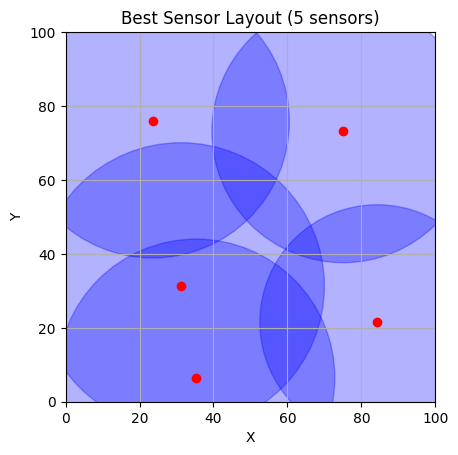

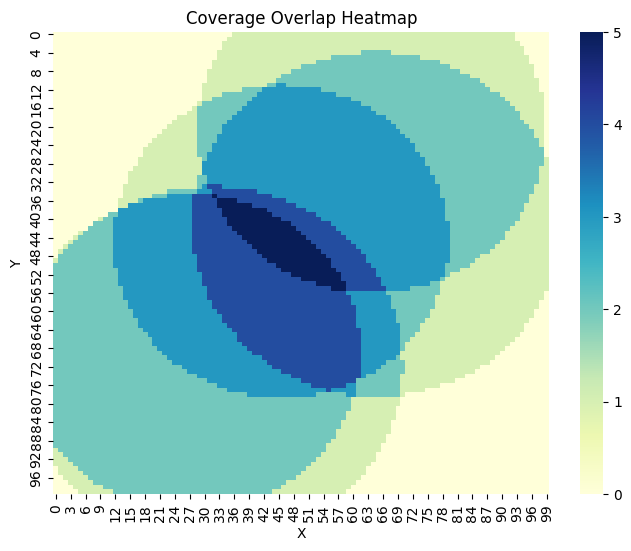

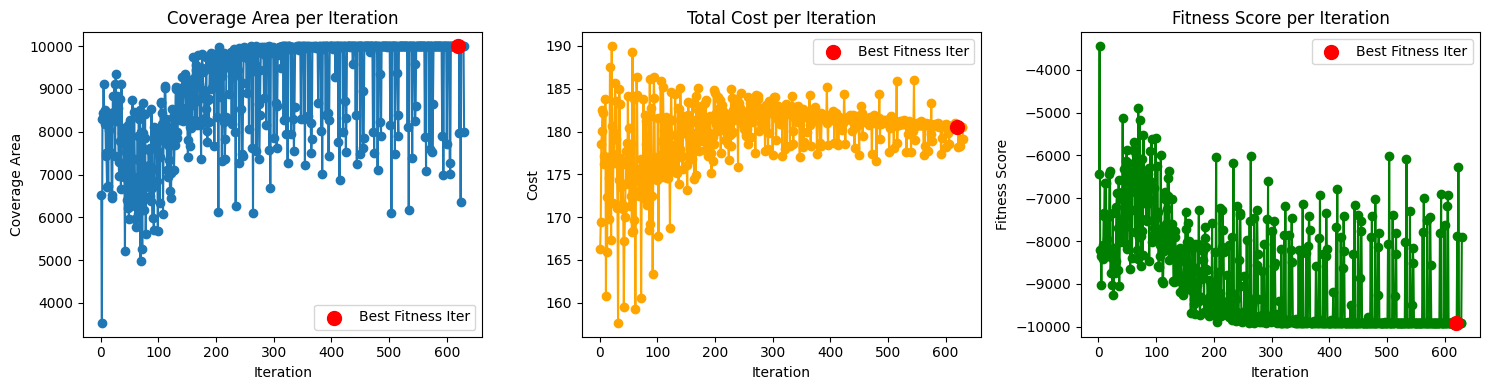

📍 Best iteration (by fitness): 619
🎯 Best fitness: -9909.76
📊 Coverage at best: 10000
💰 Cost at best: 180.48


In [13]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

# Step 1: User Input
area_width = int(input("Enter area width (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

radius_bounds = (r_min, r_max)
grid_resolution = 1

# Grid setup
x_coords = np.arange(0, area_width, grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Variables to track during optimization
fitness_history = []
coverage_history = []
cost_history = []

# Step 2: Fitness Function with Heatmap Support
def fitness_function(particle):
    global last_heatmap  # to reuse for heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat = np.zeros(len(grid_points), dtype=int)
    total_cost = 0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]
        dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat += covered.astype(int)
        total_cost += r  # radius as cost

    coverage_score = np.sum(total_covered)
    last_heatmap = heat  # store for later heatmap

    # Record values for this iteration
    fitness = -coverage_score + 0.5 * total_cost
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)

    return fitness

# Step 3: Bounds
lb = []
ub = []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# Step 4: PSO Optimization
print("⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# Step 5: Summary Info
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    covered = dist <= r
    total_covered |= covered
    total_cost += r

print(f"📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")

# Step 6: Show Sensor Layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')

for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    circle = plt.Circle((x, y), r, color='blue', alpha=0.3)
    ax.add_patch(circle)
    ax.plot(x, y, 'ro')

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Step 7: Heatmap of Coverage Overlap
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu')
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Step 8: Plot iteration history with unified best point (based on fitness)
iterations = list(range(1, len(fitness_history) + 1))

# 找到“全局最优解”所在的迭代（fitness 最小）
best_idx = np.argmin(fitness_history)
best_iter = iterations[best_idx]
best_fit = fitness_history[best_idx]
best_coverage = coverage_history[best_idx]
best_cost = cost_history[best_idx]

plt.figure(figsize=(15, 4))

# Coverage plot
plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, marker='o')
plt.scatter(best_iter, best_coverage, color='red', s=100, zorder=5, label='Best Fitness Iter')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

# Cost plot
plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, marker='o', color='orange')
plt.scatter(best_iter, best_cost, color='red', s=100, zorder=5, label='Best Fitness Iter')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

# Fitness plot
plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, marker='o', color='green')
plt.scatter(best_iter, best_fit, color='red', s=100, zorder=5, label='Best Fitness Iter')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()

# 输出统一的最优迭代信息
print(f"📍 Best iteration (by fitness): {best_iter}")
print(f"🎯 Best fitness: {best_fit:.2f}")
print(f"📊 Coverage at best: {best_coverage}")
print(f"💰 Cost at best: {best_cost:.2f}")


Enter area width (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 4):  5
Enter minimum radius (e.g. 5):  20
Enter maximum radius (e.g. 20):  25


⚙️ Start Optimization...
No constraints given.
Best after iteration 1: [69.01040127 81.06472168 24.12733933 74.00001385 38.55964764 20.24167698
 12.81940435 75.36641128 22.91542935 46.67855613 14.11139099 24.99141472
 33.8223313  71.97361686 21.86008953] -6497.932025041838
Best after iteration 2: [69.01040127 81.06472168 24.12733933 74.00001385 38.55964764 20.24167698
 12.81940435 75.36641128 22.91542935 46.67855613 14.11139099 24.99141472
 33.8223313  71.97361686 21.86008953] -6497.932025041838
Best after iteration 3: [69.01040127 81.06472168 24.12733933 74.00001385 38.55964764 20.24167698
 12.81940435 75.36641128 22.91542935 46.67855613 14.11139099 24.99141472
 33.8223313  71.97361686 21.86008953] -6497.932025041838
Best after iteration 4: [69.01040127 81.06472168 24.12733933 74.00001385 38.55964764 20.24167698
 12.81940435 75.36641128 22.91542935 46.67855613 14.11139099 24.99141472
 33.8223313  71.97361686 21.86008953] -6497.932025041838
New best for swarm at iteration 5: [81.184270

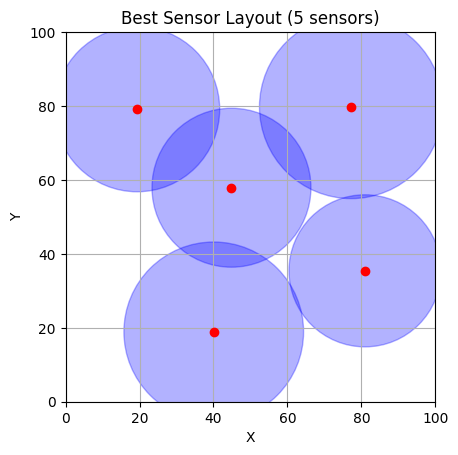

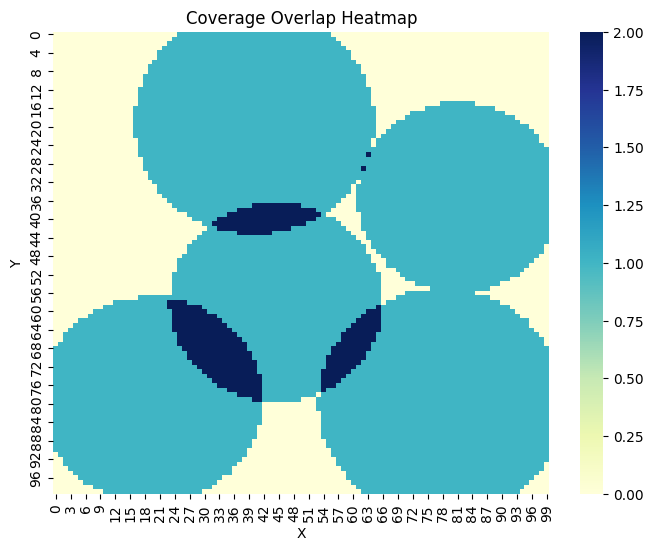

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

# Step 1: User Input
area_width = int(input("Enter area width (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

radius_bounds = (r_min, r_max)
grid_resolution = 1

# Grid setup
x_coords = np.arange(0, area_width, grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Step 2: Fitness Function with Heatmap Support
def fitness_function(particle):
    global last_heatmap  # to reuse for heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat = np.zeros(len(grid_points), dtype=int)
    total_cost = 0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]
        dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat += covered.astype(int)
        total_cost += r  # radius as cost

    coverage_score = np.sum(total_covered)
    last_heatmap = heat  # store for later heatmap
    return -coverage_score + 0.5 * total_cost  # lower is better

# Step 3: Bounds
lb = []
ub = []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# Step 4: PSO Optimization
print("⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# Step 5: Summary Info
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    covered = dist <= r
    total_covered |= covered
    total_cost += r

print(f"📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")

# Step 6: Show Sensor Layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')

for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    circle = plt.Circle((x, y), r, color='blue', alpha=0.3)
    ax.add_patch(circle)
    ax.plot(x, y, 'ro')

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Step 7: Heatmap of Coverage Overlap
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu')
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()


Enter area width (e.g. 100):  100
Enter area height (e.g. 100):  100
Enter number of sensors (e.g. 4):  30
Enter minimum radius (e.g. 5):  40
Enter maximum radius (e.g. 20):  45


⚙️ Start Optimization...
No constraints given.
New best for swarm at iteration 1: [ 28.35801082  24.58441155  40.          78.64279435 100.
  43.6429238   69.28027661 100.          44.50604599  72.64264647
  87.5825921   45.          30.11542666   6.63336438  40.23268446
  18.11866948  50.57651206  42.01015963  77.90707143  76.81812367
  43.35381147  81.89296612  57.41715417  42.21781745  12.00918222
  52.04388442  40.           0.          54.60027798  41.63131459
  75.42753213 100.          40.61227974  42.04135885  13.47305588
  41.54029553  66.99945815  75.8497888   41.92903978  42.9250135
  72.18034365  41.73951949  65.53593532  89.88275298  42.21947767
  37.62655056 100.          40.          13.06297212  61.28629686
  43.21800937  16.68313261  35.42981928  41.69208183   0.
  74.49795769  41.84324577  43.35256371  82.39704991  42.15613849
  74.26281818  74.34294332  40.7578496    0.          84.1139927
  42.00011887   9.65335696  40.31632902  41.01505519  93.08006197
  70.1687402

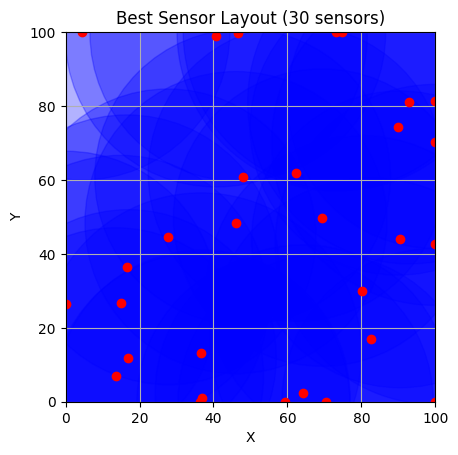

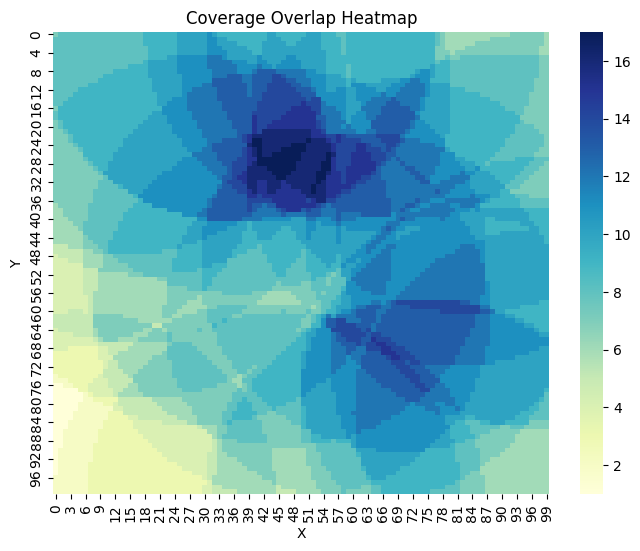

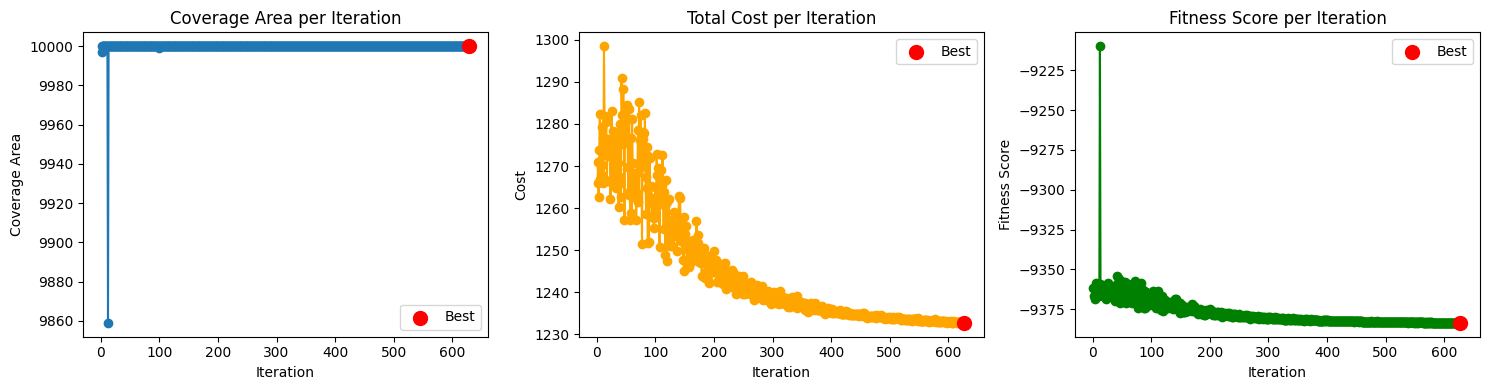

📍 Best iteration: 628
🎯 Best fitness: -9383.66
📊 Coverage at best: 10000
💰 Cost at best: 1232.67


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pyswarm import pso

# Step 1: User Input
area_width = int(input("Enter area width (e.g. 100): "))
area_height = int(input("Enter area height (e.g. 100): "))
sensor_count = int(input("Enter number of sensors (e.g. 4): "))
r_min = float(input("Enter minimum radius (e.g. 5): "))
r_max = float(input("Enter maximum radius (e.g. 20): "))

radius_bounds = (r_min, r_max)
grid_resolution = 1

# Grid setup
x_coords = np.arange(0, area_width, grid_resolution)
y_coords = np.arange(0, area_height, grid_resolution)
xx, yy = np.meshgrid(x_coords, y_coords)
grid_points = np.c_[xx.ravel(), yy.ravel()]

# Variables to track during optimization
fitness_history = []
coverage_history = []
cost_history = []

# Step 2: Fitness Function with Heatmap Support
def fitness_function(particle):
    global last_heatmap  # to reuse for heatmap
    total_covered = np.zeros(len(grid_points), dtype=bool)
    heat = np.zeros(len(grid_points), dtype=int)
    total_cost = 0

    for i in range(sensor_count):
        x = particle[i*3]
        y = particle[i*3 + 1]
        r = particle[i*3 + 2]
        dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
        covered = dist <= r
        total_covered |= covered
        heat += covered.astype(int)
        total_cost += r  # radius as cost

    coverage_score = np.sum(total_covered)
    last_heatmap = heat  # store for later heatmap

    # Record values for this iteration
    fitness = -coverage_score + 0.5 * total_cost
    fitness_history.append(fitness)
    coverage_history.append(coverage_score)
    cost_history.append(total_cost)

    return fitness

# Step 3: Bounds
lb = []
ub = []
for _ in range(sensor_count):
    lb.extend([0, 0, radius_bounds[0]])
    ub.extend([area_width, area_height, radius_bounds[1]])

# Step 4: PSO Optimization
print("⚙️ Start Optimization...")
best_position, best_score = pso(
    fitness_function,
    lb=lb,
    ub=ub,
    swarmsize=30,
    maxiter=20,
    debug=True
)
print("✅ Optimization Complete")

# Step 5: Summary Info
total_covered = np.zeros(len(grid_points), dtype=bool)
total_cost = 0
for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    dist = np.sqrt((grid_points[:, 0] - x) ** 2 + (grid_points[:, 1] - y) ** 2)
    covered = dist <= r
    total_covered |= covered
    total_cost += r

print(f"📊 Final Coverage Area: {np.sum(total_covered)}")
print(f"💰 Total Cost: {total_cost:.2f}")
print(f"🎯 Fitness Score: {best_score:.2f}")

# Step 6: Show Sensor Layout
fig, ax = plt.subplots()
ax.set_xlim(0, area_width)
ax.set_ylim(0, area_height)
ax.set_aspect('equal')
ax.set_title(f'Best Sensor Layout ({sensor_count} sensors)')

for i in range(sensor_count):
    x = best_position[i*3]
    y = best_position[i*3 + 1]
    r = best_position[i*3 + 2]
    circle = plt.Circle((x, y), r, color='blue', alpha=0.3)
    ax.add_patch(circle)
    ax.plot(x, y, 'ro')

plt.grid(True)
plt.xlabel("X")
plt.ylabel("Y")
plt.show()

# Step 7: Heatmap of Coverage Overlap
heatmap = last_heatmap.reshape((len(y_coords), len(x_coords)))
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap, cmap='YlGnBu')
plt.title('Coverage Overlap Heatmap')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Step 8: Plot iteration history with best point highlighted
iterations = list(range(1, len(fitness_history) + 1))

# 找到最优迭代（fitness 最小值）
best_idx = np.argmin(fitness_history)
best_iter = iterations[best_idx]
best_fit = fitness_history[best_idx]
best_coverage = coverage_history[best_idx]
best_cost = cost_history[best_idx]

plt.figure(figsize=(15, 4))

# Coverage plot
plt.subplot(1, 3, 1)
plt.plot(iterations, coverage_history, marker='o')
plt.scatter(best_iter, best_coverage, color='red', s=100, zorder=5, label='Best')
plt.title("Coverage Area per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Coverage Area")
plt.legend()

# Cost plot
plt.subplot(1, 3, 2)
plt.plot(iterations, cost_history, marker='o', color='orange')
plt.scatter(best_iter, best_cost, color='red', s=100, zorder=5, label='Best')
plt.title("Total Cost per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.legend()

# Fitness plot
plt.subplot(1, 3, 3)
plt.plot(iterations, fitness_history, marker='o', color='green')
plt.scatter(best_iter, best_fit, color='red', s=100, zorder=5, label='Best')
plt.title("Fitness Score per Iteration")
plt.xlabel("Iteration")
plt.ylabel("Fitness Score")
plt.legend()

plt.tight_layout()
plt.show()

# 打印最优迭代信息
print(f"📍 Best iteration: {best_iter}")
print(f"🎯 Best fitness: {best_fit:.2f}")
print(f"📊 Coverage at best: {best_coverage}")
print(f"💰 Cost at best: {best_cost:.2f}")
